In [13]:
import os
import sys
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToTensor, Compose, ConvertImageDtype
import torch.nn.functional as F

from Data_manager import SegmentationDataset, collate_fn

In [2]:
print(torch.version.cuda)

12.9


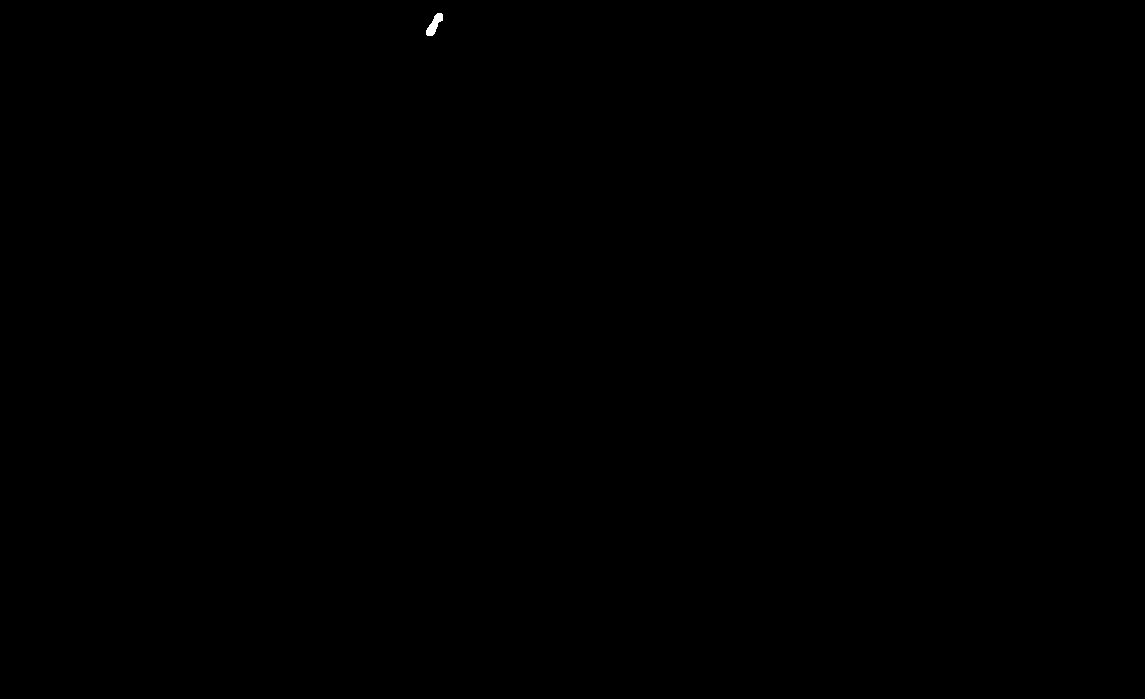

In [3]:
mask = Image.open('../data/Hesperidine_u87m6_5_10_g_neg/u87m6_5_k_g/labels/7.png')
mask.show()

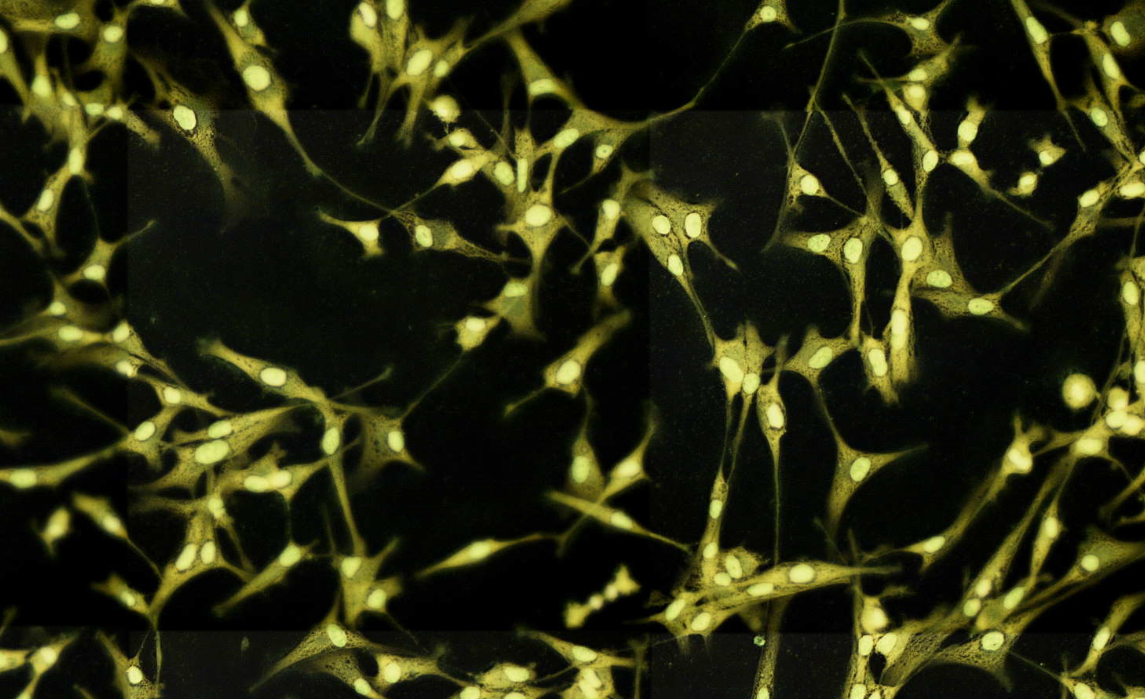

In [4]:
image = Image.open('../data/Hesperidine_u87m6_5_10_g_neg/u87m6_5_k_g6.tif')
image.show()

In [5]:
labels_dir = '../data/Hesperidine_u87m6_5_10_g_neg/u87m6_5_k_g/labels'
transform = Compose([ToTensor(), ConvertImageDtype(torch.float)])
mask_files = sorted(os.listdir(labels_dir), key=lambda x: int(x.split('.')[0]))
masks = []
for mf in mask_files:
    mask_path = os.path.join(labels_dir, mf)
    mask = Image.open(mask_path) #.convert('L')
    # mask.show()
    masks.append(mask)
mask_tensors = []
boxes = []
for mask in masks:
    mask_tensor = transform(mask) 
    mask_tensor = (mask_tensor > 0).float() 
            
    if mask_tensor.sum() == 0: 
        continue
    y_indices, x_indices = torch.nonzero(mask_tensor[0] > 0, as_tuple=True)
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    boxes.append([x_min.item(), y_min.item(), x_max.item() + 1, y_max.item() + 1])  # [xmin, ymin, xmax, ymax]
            
    mask_tensors.append(mask_tensor)  


print(len(boxes))

132


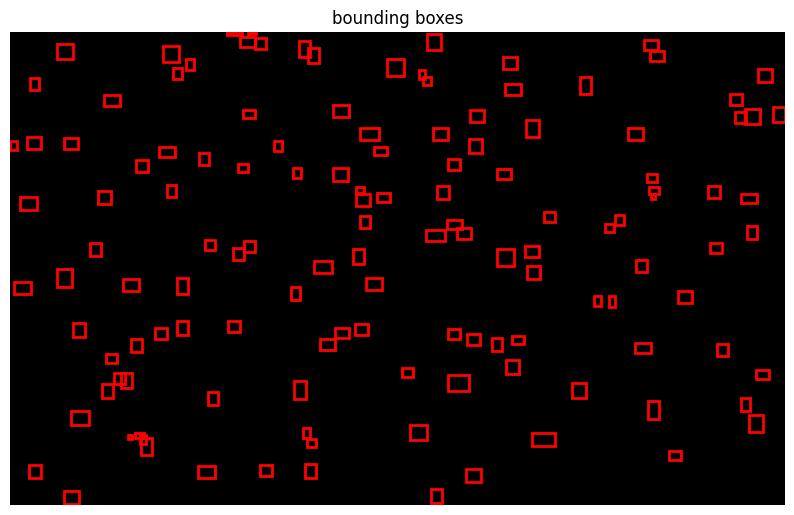

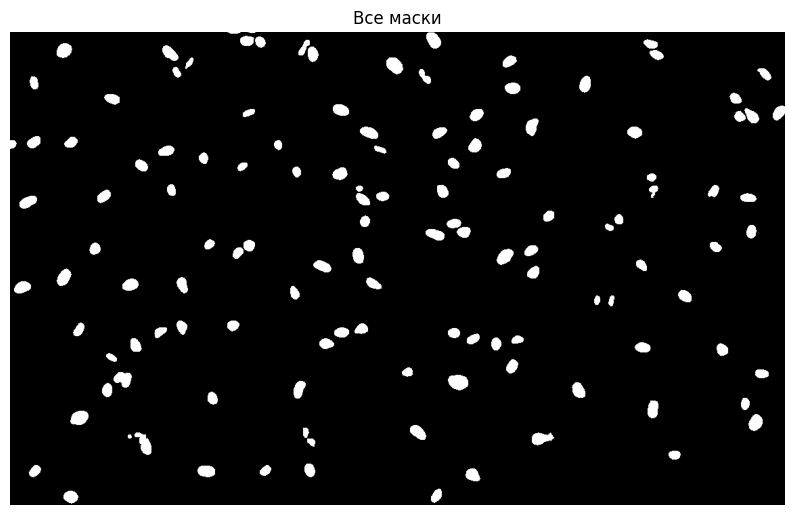

In [6]:
# test
H, W = mask_tensors[0].shape[1], mask_tensors[0].shape[2] 


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
black_bg = np.zeros((H, W, 3))  
ax.imshow(black_bg) 

for box in boxes:
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title("bounding boxes")
ax.axis('off')  
plt.show()

all_masks_sum = torch.sum(torch.stack(mask_tensors), dim=0).squeeze(0).numpy()  
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(all_masks_sum, cmap='gray')  
ax.set_title("Все маски")
ax.axis('off')
plt.show()


In [7]:
train_root_dir = '../data/Hesperidine_u87m6_5_10_g_neg'
train_dataset = SegmentationDataset(train_root_dir)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=False, collate_fn = collate_fn)

In [8]:
len(train_loader)

33

In [ ]:
device = 'cuda'
num_epochs = 20
num_classes = 3
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=hidden_layer, dim_reduced=hidden_layer, num_classes=num_classes)

model.to(device)

In [10]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [11]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, targets = batch
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Обучение
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")  

Epoch 1/20: 100%|██████████| 33/33 [00:33<00:00,  1.01s/it]


Epoch [1/20], Loss: 1.4177


Epoch 2/20: 100%|██████████| 33/33 [00:33<00:00,  1.00s/it]


Epoch [2/20], Loss: 0.8439


Epoch 3/20: 100%|██████████| 33/33 [00:32<00:00,  1.02it/s]


Epoch [3/20], Loss: 0.7310


Epoch 4/20: 100%|██████████| 33/33 [00:32<00:00,  1.01it/s]


Epoch [4/20], Loss: 0.6970


Epoch 5/20: 100%|██████████| 33/33 [00:32<00:00,  1.02it/s]


Epoch [5/20], Loss: 0.6720


Epoch 6/20: 100%|██████████| 33/33 [00:31<00:00,  1.04it/s]


Epoch [6/20], Loss: 0.6706


Epoch 7/20: 100%|██████████| 33/33 [00:32<00:00,  1.02it/s]


Epoch [7/20], Loss: 0.6683


Epoch 8/20: 100%|██████████| 33/33 [00:32<00:00,  1.02it/s]


Epoch [8/20], Loss: 0.6699


Epoch 9/20: 100%|██████████| 33/33 [00:32<00:00,  1.03it/s]


Epoch [9/20], Loss: 0.6672


Epoch 10/20: 100%|██████████| 33/33 [00:32<00:00,  1.01it/s]


Epoch [10/20], Loss: 0.6659


Epoch 11/20: 100%|██████████| 33/33 [00:32<00:00,  1.02it/s]


Epoch [11/20], Loss: 0.6632


Epoch 12/20: 100%|██████████| 33/33 [00:32<00:00,  1.02it/s]


Epoch [12/20], Loss: 0.6663


Epoch 13/20: 100%|██████████| 33/33 [00:31<00:00,  1.04it/s]


Epoch [13/20], Loss: 0.6657


Epoch 14/20: 100%|██████████| 33/33 [00:32<00:00,  1.02it/s]


Epoch [14/20], Loss: 0.6690


Epoch 15/20: 100%|██████████| 33/33 [00:32<00:00,  1.03it/s]


Epoch [15/20], Loss: 0.6631


Epoch 16/20: 100%|██████████| 33/33 [00:32<00:00,  1.03it/s]


Epoch [16/20], Loss: 0.6638


Epoch 17/20: 100%|██████████| 33/33 [00:32<00:00,  1.03it/s]


Epoch [17/20], Loss: 0.6675


Epoch 18/20: 100%|██████████| 33/33 [00:31<00:00,  1.04it/s]


Epoch [18/20], Loss: 0.6638


Epoch 19/20: 100%|██████████| 33/33 [00:32<00:00,  1.03it/s]


Epoch [19/20], Loss: 0.6690


Epoch 20/20: 100%|██████████| 33/33 [00:31<00:00,  1.03it/s]

Epoch [20/20], Loss: 0.6654


In [12]:
torch.save(model.state_dict(), '../trained/test_mask_rcnn.pth')
print("Модель сохранена как test_mask_rcnn.pth")

Модель сохранена как test_mask_rcnn.pth


In [47]:
def visualize_prediction(image, prediction, threshold=0.5):
    image = image.permute(1, 2, 0).cpu().numpy()  
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    
    for box, label, score, mask in zip(prediction['boxes'], prediction['labels'], prediction['scores'], prediction['masks']):
        if score > threshold:

            rect = patches.Rectangle((box[0].item(), box[1].item()), box[2].item() - box[0].item(), box[3].item() - box[1].item(),
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            # ax.text(box[0].item(), box[1].item() - 5, f'{label}',
            #         color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
            
            mask = mask[0].cpu().numpy()
            mask = np.ma.masked_where(mask <= 0.5, mask)
            ax.imshow(mask, alpha=1.0, cmap='jet')
    
    plt.axis('off')
    plt.show()

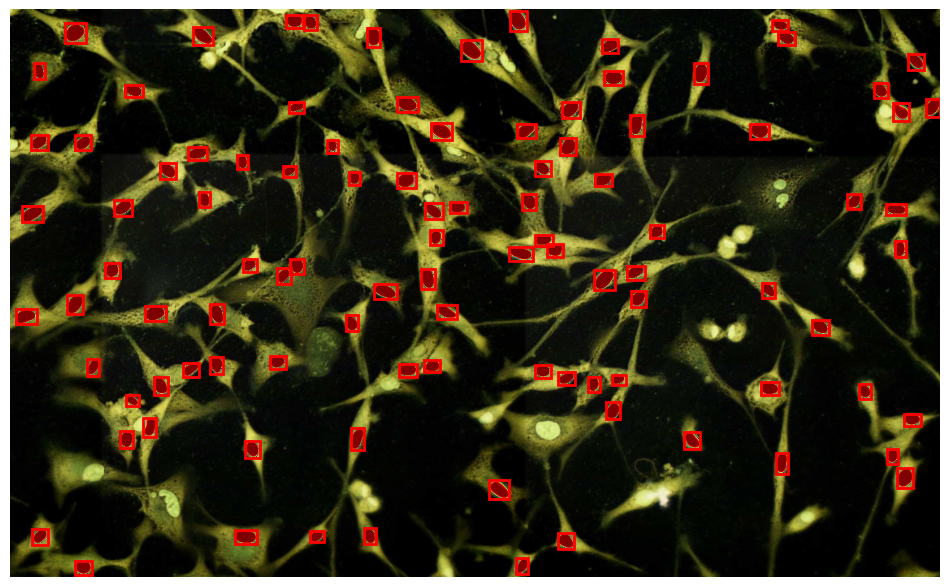

In [46]:
device = 'cuda'
num_classes = 3
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=None)  
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=hidden_layer, dim_reduced=hidden_layer, num_classes=num_classes)

model.load_state_dict(torch.load('../trained/test_mask_rcnn.pth'))
model.to(device)
model.eval()

img_path = '../data/Hesperidine_u87m6_5_10_g_neg/u87m6_5_k_g.tif'
transform = Compose([ToTensor(), ConvertImageDtype(torch.float)])
image = Image.open(img_path).convert("RGB")
image_tensor = transform(image).to(device)

with torch.no_grad():
    pred = model([image_tensor])[0]

visualize_prediction(image_tensor, pred)

In [ ]:
# center_csv = os.path.join('../data/Hesperidine_u87m6_5_10_g_neg/u87m6_5_k_g/primary/u87m6_5_k_g_Center.csv')
# size_roundness_csv = os.path.join('../data/Hesperidine_u87m6_5_10_g_neg/u87m6_5_k_g/primary/u87m6_5_k_g_size_roundness.csv')
        
# info = pd.concat([pd.read_csv(center_csv, names=['x', 'y']), pd.read_csv(size_roundness_csv, names=['size', 'roundness'])], axis = 1)
# info['classes'] = info['size'].apply(lambda x: 1 if x <= 40 else 2)
# info